In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple
from adabmDCA.fasta import get_tokens
import h5py

import torch
from annadca import annaRBMcat
from annadca.dataset import DatasetCat
from annadca.utils import get_eigenvalues_history
from annadca.plot import plot_PCA

### Plot the results

In [49]:
#fname_data = "/home/rosset/data/PF00072/PF00072.fasta"
#fname_ann = "/home/rosset/data/PF00072/PF00072_ann.csv"
#fname_weights = "/home/rosset/data/PF00072/PF00072_weights.dat"
#fname_chains = "/home/rosset/models/PF00072/annaDCA_chains.fasta"
#fname_model = "/home/rosset/models/PF00072/annaDCA_params.h5"

fname_data = "/home/rosset/data/Test/SAM/SAM.fasta"
fname_ann = "/home/rosset/data/Test/SAM/SAM_ann.csv"
fname_weights = None
fname_chains = "/home/rosset/models/SAM/annaDCA_chains.fasta"
fname_model = "/home/rosset/models/SAM/annaDCA_params.h5"

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [56]:
tokens = get_tokens("rna")
rbm = annaRBMcat()
dataset = DatasetCat(
    path_data=fname_data,
    path_ann=fname_ann,
    path_weights=fname_weights,
    alphabet=tokens,
    device=device,
)

data_flat = dataset.data_one_hot.view(len(dataset.data), -1)
weights = dataset.weights.view(-1)
labels_data = dataset.to_label(dataset.labels_one_hot)

idxs = torch.multinomial(weights, len(dataset.data), replacement=True).cpu()
data_flat = data_flat[idxs]
labels_data = labels_data[idxs]

chains = rbm.load_chains(filename=fname_chains, alphabet=tokens, device=device, dtype=dtype)
labels_chains = dataset.to_label(chains["label"])

Automatically computing the sequence weights...
Multi-sequence alignment imported: M = 5257, L = 108, q = 5, M_eff = 1066.


In [57]:
# project data and chains
_, _, Vt = torch.linalg.svd(data_flat - data_flat.mean(0), full_matrices=False)
data_proj = data_flat @ Vt.T / dataset.get_num_residues()**0.5
chains_proj = chains["visible"].view(len(chains["visible"]), -1) @ Vt.T / dataset.get_num_residues()**0.5
data_proj = data_proj.cpu().numpy()
chains_proj = chains_proj.cpu().numpy()

In [58]:
# Define the colors
unique_labels = np.unique(labels_data)
cmap = plt.get_cmap("tab10", len(unique_labels))
label_to_color = {label.item(): cmap(i) for i, label in enumerate(unique_labels)}

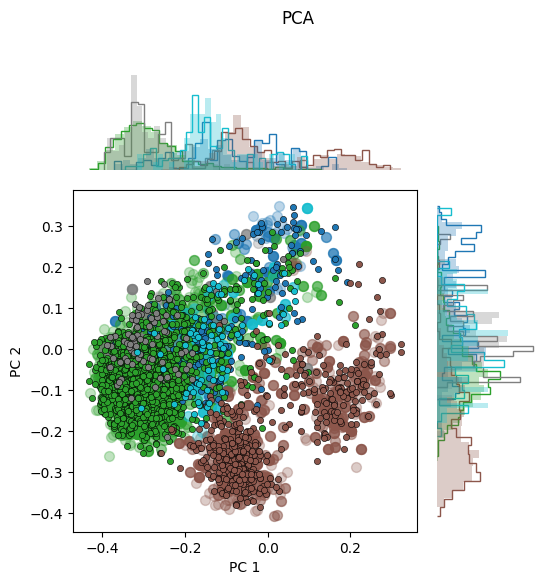

In [59]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data,
    data2=chains_proj,
    labels2=labels_chains,
    label_to_color=label_to_color,
    dim1=0,
    dim2=1,
    title="PCA",
    split_labels=True,
)


In [60]:
updates, eigenvalues = get_eigenvalues_history(fname_model, target_matrix="weight_matrix", device=device, dtype=dtype)
updates, eigenvalues_labels = get_eigenvalues_history(fname_model, target_matrix="label_matrix", device=device, dtype=dtype)

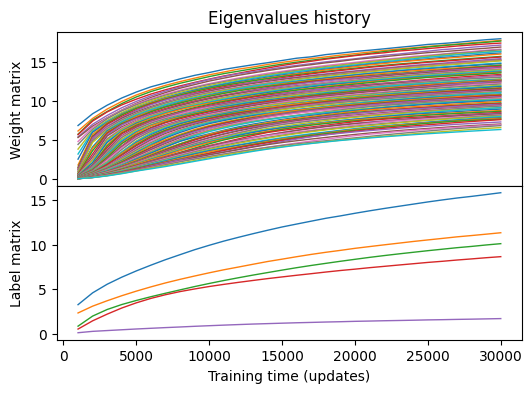

In [61]:
# Plot the eigenvalues history. first row is the weight matrix, second row is the label matrix. xaxis is shared and there is no border between the plots
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'hspace': 0})
ax[0].plot(updates, eigenvalues, lw=1)
ax[1].plot(updates, eigenvalues_labels, lw=1)
ax[1].set_xlabel("Training time (updates)")
ax[0].set_ylabel("Weight matrix")
ax[1].set_ylabel("Label matrix")
#ax[0].set_xscale("log")
#ax[1].set_yscale("log")
#ax[0].set_yscale("log")
ax[0].set_title("Eigenvalues history");

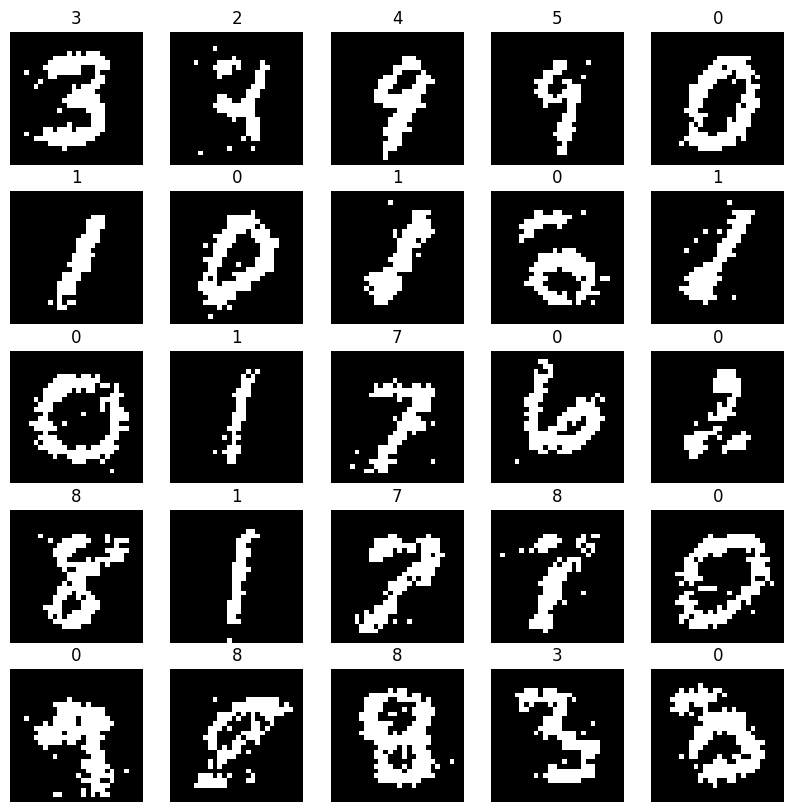

In [ ]:
# Visualize the first 25 chains as mnist images with the corresponding labels
l = chains["label"]
first_25_labels = dataset.to_label(l)[:25]
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(chains[i].cpu().numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(labels_chains[i])

### Conditioned sampling

In [69]:
rbm.load(fname_model, device=device, dtype=dtype)
init_chains = rbm.init_chains(num_samples=dataset.__len__())
cond_chains = rbm.sample_conditioned(
    gibbs_steps=50000,
    chains=init_chains,
    targets=dataset.labels_one_hot[idxs],
)

In [70]:
cond_chains_proj = cond_chains.view(len(cond_chains), -1) @ Vt.T / cond_chains.shape[1]**0.5
cond_chains_labels = labels_data
cond_chains_proj = cond_chains_proj.cpu().numpy()

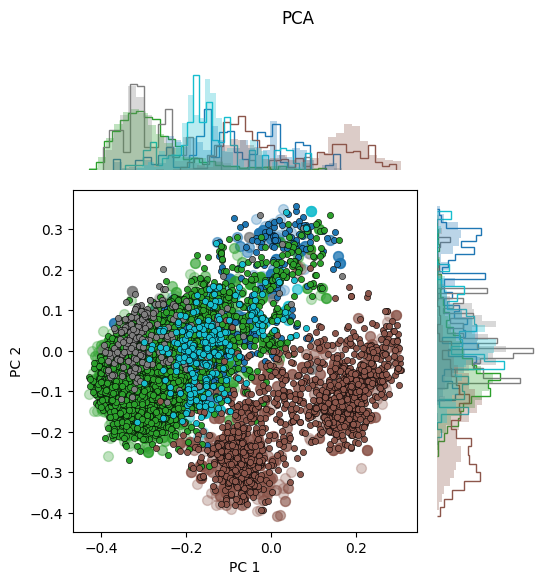

In [71]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data,
    data2=cond_chains_proj,
    labels2=cond_chains_labels,
    label_to_color=label_to_color,
    dim1=0,
    dim2=1,
    title="PCA",
    split_labels=True,
)

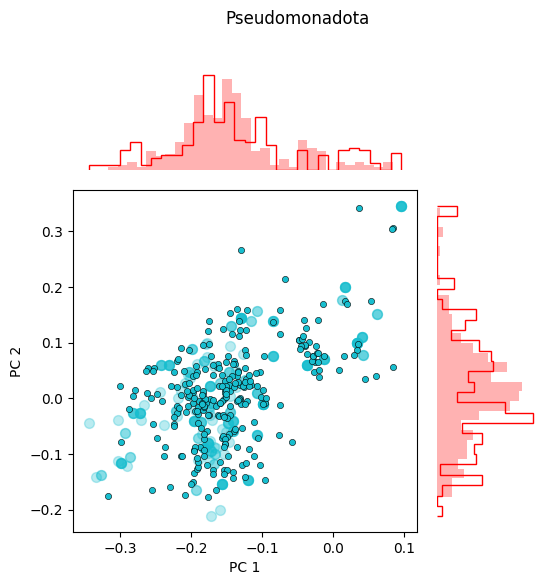

In [77]:
# Plot pca of conditioned chains and data but only one label
label_idx = 4
label = dataset.idx_to_label[label_idx]
mask_data = labels_data == label
mask_gen = cond_chains_labels == label
data_proj_label = data_proj[mask_data]
chains_proj_label = cond_chains_proj[mask_gen]

fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj_label,
    labels1=labels_data[mask_data],
    data2=chains_proj_label,
    labels2=cond_chains_labels[mask_gen],
    label_to_color={label: cmap(label_idx)},
    dim1=0,
    dim2=1,
    title=label,
    split_labels=False,
)

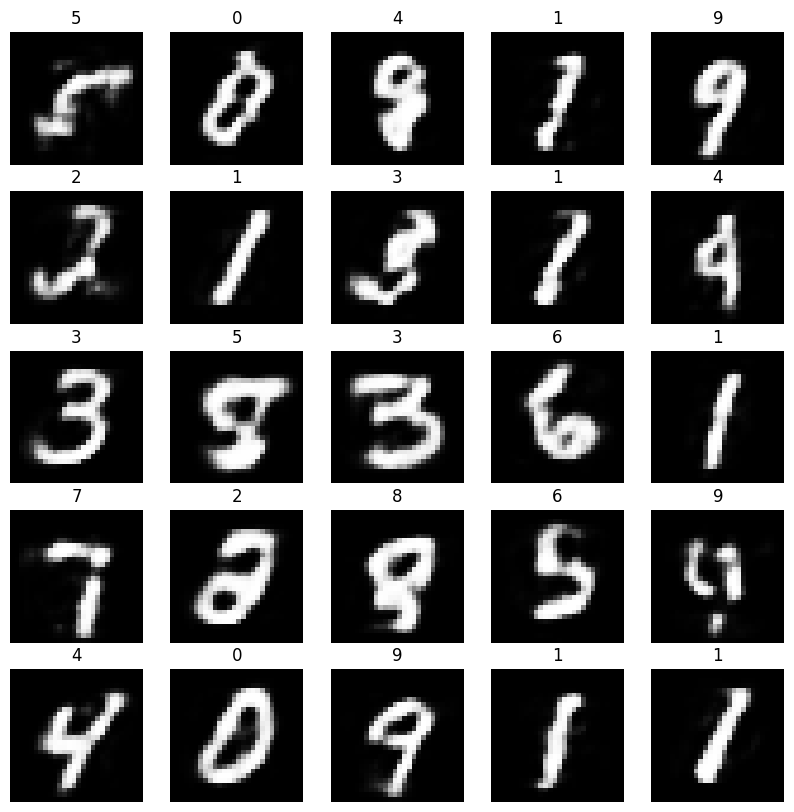

In [17]:
# Visualize the first 25 chains as mnist images with the corresponding labels
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(cond_chains["visible"][i].cpu().numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(cond_chains_labels[i])

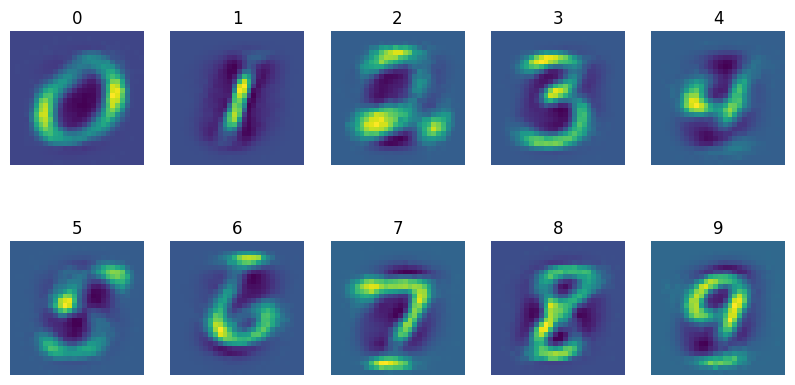

In [ ]:
from annadca.utils import mutual_information
Iil = mutual_information(
    visible=cond_chains,
    label=labels_data,
)

# Plot an image of the mutual information between labels and chains for each label
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(Iil[i].cpu().numpy().reshape(28, 28), cmap='viridis')
    ax.axis('off')
    ax.set_title(i)

### Predict labels of the data

In [78]:
predictions = rbm.predict_labels(
    gibbs_steps=10000,
    chains=init_chains,
    targets=dataset.data_one_hot,
)

In [79]:
accuracy = (predictions.argmax(-1) == dataset.labels_one_hot.argmax(-1)).float().mean().item()
print(f"Train accuracy: {accuracy}")

Train accuracy: 0.9842115640640259
